In [24]:
import jax
import jax.numpy as jnp

import numpy as np

import haiku as hk

import matplotlib.pyplot as plt

from models.mlp import lenet_fn

def hvp(f, x, v):
    return jax.grad(lambda x: jnp.vdot(jax.grad(f)(x), v))(x)


def ravel_pytree(pytree):
    leaves, treedef = jax.tree_flatten(pytree)
    return jnp.concatenate([jnp.ravel(elt) for elt in leaves],axis=0)


def get_quadratic_approx(f,w0):



    def approx(w,x):

        ff = lambda w,x: jnp.squeeze(f(w,x))

        grad_fun = lambda w: ravel_pytree(jax.grad(ff)(w,x))

        delta = ravel_pytree(jax.tree_map(lambda a,b: a-b, w,w0))

        # Get constant term
        const = f(w0,x)

        # Get linear term
        linear = delta @ grad_fun(w0)

        # Get quadratic term 
        quadratic = 0.5 * delta @ ravel_pytree(jax.grad(lambda w: jnp.vdot(grad_fun(w), delta))(w0))
       
        # return const + linear
        return const + linear + quadratic
        # return const + quadratic

    return approx


net = hk.without_apply_rng(hk.transform(lenet_fn))

rng = hk.PRNGSequence(jax.random.PRNGKey(42))

x = jnp.ones([1, 28 * 28])

w0 = net.init(next(rng), x)

q = get_quadratic_approx(net.apply,w0)

d = net.init(next(rng), x)

/tmp/ipykernel_24954/1737795685.py:17: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(pytree)


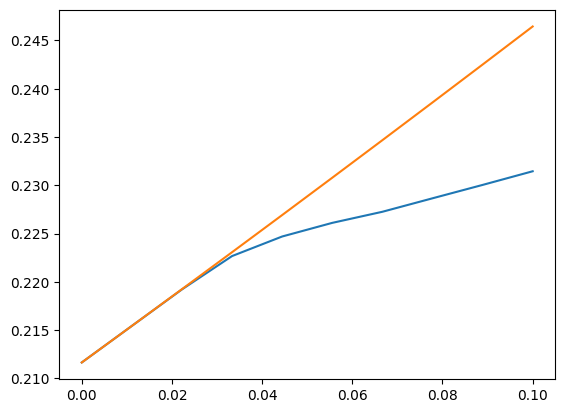

In [25]:
alphas = np.linspace(0,0.1,10)
f_orig = np.zeros_like(alphas)
f_approx = np.zeros_like(alphas)

for ind,alpha in enumerate(alphas):

    w = jax.tree_map(lambda a,b: a+alpha*b, w0, d)
    f_orig[ind] = net.apply(w,x)
    f_approx[ind] = q(w,x)


plt.plot(alphas,f_orig)
plt.plot(alphas,f_approx)
plt.show()